https://www.tensorflow.org/tutorials/images/transfer_learning

In [1]:
import os
from pathlib import Path
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Config

In [2]:
os.environ['KMP_DUPLICATE_LIB_OK']='True' # fixes error with libiomp5.dll
RANDOM_STATE = 42
UNZIP_IMAGES = False
RESIZE_IMAGES = False
MOVE_IMAGES = False

In [3]:
id_label = pd.read_csv('data\\train.csv')
id_label.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


In [4]:
id_label.count()

id            17500
has_cactus    17500
dtype: int64

In [5]:
id_label.groupby('has_cactus').count()

,id
has_cactus,
0,4364
1,13136


### Observations
- The data is skewed towards images that have a cactus
- i.e. by always guessing 1, the accuracy would be 75%
- Need to augment the `has_cactus == 0` data

## Separate data into train and validation set

In [6]:
VALIDATION_SET_SIZE = 3500 # 20%

neg_indices = id_label[id_label['has_cactus'] == 0].index
pos_indices = id_label[id_label['has_cactus'] == 1].index

neg_val = np.random.choice(neg_indices, VALIDATION_SET_SIZE // 2)
pos_val = np.random.choice(pos_indices, VALIDATION_SET_SIZE // 2)

In [7]:
id_label['no_cactus'] = pd.Series(np.ones((id_label.shape[0],)) - id_label['has_cactus'], dtype=np.int64)
id_label.head()


,id,has_cactus,no_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1,0
1,000c8a36845c0208e833c79c1bffedd1.jpg,1,0
2,000d1e9a533f62e55c289303b072733d.jpg,1,0
3,0011485b40695e9138e92d0b3fb55128.jpg,1,0
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1,0


In [8]:
# confirm that `no_cactus` is the opposite of `has_cactus`
assert id_label['has_cactus'].sum() + id_label['no_cactus'].sum() == id_label.shape[0]
id_label.where(id_label['has_cactus'] == id_label['no_cactus']).count()

id            0
has_cactus    0
no_cactus     0
dtype: int64

In [9]:
# splitting the validation classes 50:50 in case the model is biased towards predicting positive,
# it will perform poorly on the validation set
pos_val = id_label.sample(VALIDATION_SET_SIZE // 2, weights='has_cactus', random_state=RANDOM_STATE)
neg_val = id_label.sample(VALIDATION_SET_SIZE // 2, weights='no_cactus' , random_state=RANDOM_STATE)

In [10]:
print('pos count:', pos_val['has_cactus'].sum())
print('neg count:', neg_val['no_cactus'].sum())

pos count: 1750
neg count: 1750


In [11]:
train_df = id_label.drop(pos_val.index).drop(neg_val.index)
train_df.shape

(14000, 3)

In [12]:
val_df = pd.concat([pos_val, neg_val])
val_df.shape

(3500, 3)

In [13]:
train_df['has_cactus'].value_counts()

has_cactus
1    11386
0     2614
Name: count, dtype: int64

In [14]:
neg_count, pos_count = np.bincount(train_df['has_cactus'])

print(f'Pos:Neg ratio = {pos_count} / {neg_count} = {pos_count / neg_count:.2f}', )

Pos:Neg ratio = 11386 / 2614 = 4.36


- About 4x as many positives as negitives
- Can increase the weight of a negative by 4
- Could downsample but this may reduce the training data too much

In [15]:
def resize_images(src: Path, new_size: tuple[int, int]):
    for img_path in src.iterdir():
        with Image.open(img_path, 'r') as img:
            resized = img.resize(new_size)
        resized.save(img_path)

In [16]:
def move_images_to_folder(src: Path, dst:Path, df: pd.DataFrame) -> None:
    has_cactus = dst.joinpath('has_cactus')
    no_cactus = dst.joinpath('no_cactus')

    ensure_folders_exist([has_cactus, no_cactus])

    for i, row in df.iterrows():
        if i in df.index:
            img_path = src.joinpath(row['id'])
            move_to_class_folder(img_path, [has_cactus, no_cactus], row)


def ensure_folders_exist(paths: list[Path]) -> None:
    for path in paths:
        if not path.parent.exists():
            path.parent.mkdir()
        if not path.exists():
            path.mkdir()


def move_to_class_folder(img_path: Path, class_dirs: list[Path], row: pd.Series) -> None:
    if row['has_cactus'] == 1:
        img_path.rename(class_dirs[0].joinpath(row['id']))
    else:
        img_path.rename(class_dirs[1].joinpath(row['id']))

In [17]:
TRAIN_ZIP = Path('data\\train.zip')
TRAIN_DIR  = Path('data\\train')
VAL_DIR = Path('data\\validation')
IMG_SIZE = (96, 96)

if UNZIP_IMAGES:
    with zipfile.ZipFile(TRAIN_ZIP, 'r') as my_zip:
        my_zip.extractall(TRAIN_ZIP.parent)

if RESIZE_IMAGES:
    resize_images(TRAIN_DIR, IMG_SIZE) # images come in `train.zip` so are extracted to `train`

if MOVE_IMAGES:
    move_images_to_folder(TRAIN_DIR, TRAIN_DIR, train_df)
    move_images_to_folder(TRAIN_DIR, VAL_DIR, val_df)

In [18]:
def count_images(src: Path) -> int:
    count = 0
    for path in src.iterdir():
        if path.is_dir():
            count += count_images(path)
        elif path.is_file():
            count += 1
    return count

print(count_images(TRAIN_DIR))
print(count_images(VAL_DIR))

14000
3500


In [19]:
# Check the correct amount of images in each path
assert count_images(VAL_DIR.joinpath('has_cactus')) == val_df['has_cactus'].sum()
assert count_images(VAL_DIR.joinpath('no_cactus')) == val_df['no_cactus'].sum()
assert count_images(TRAIN_DIR.joinpath('has_cactus')) == train_df['has_cactus'].sum()
assert count_images(TRAIN_DIR.joinpath('no_cactus')) == train_df['no_cactus'].sum()

## Preprocess data

In [20]:
BATCH_SIZE = 32

train_dataset = keras.utils.image_dataset_from_directory(TRAIN_DIR,
                                                        shuffle=True,
                                                        batch_size=BATCH_SIZE,
                                                        image_size=IMG_SIZE)

val_dataset = keras.utils.image_dataset_from_directory(VAL_DIR,
                                                       shuffle=True,
                                                       batch_size=BATCH_SIZE,
                                                       image_size=IMG_SIZE)

Found 14000 files belonging to 2 classes.
Found 3500 files belonging to 2 classes.


In [21]:
class_names = train_dataset.class_names
print(class_names)

['has_cactus', 'no_cactus']


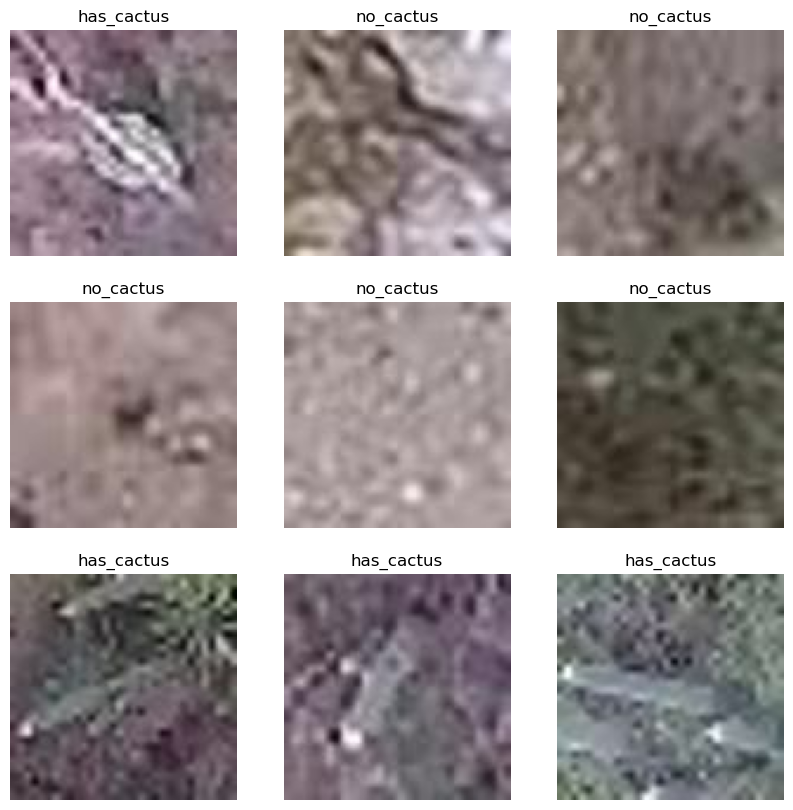

In [22]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [23]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
# test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)



In [24]:
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip('horizontal'),
    keras.layers.RandomRotation(0.2),
])

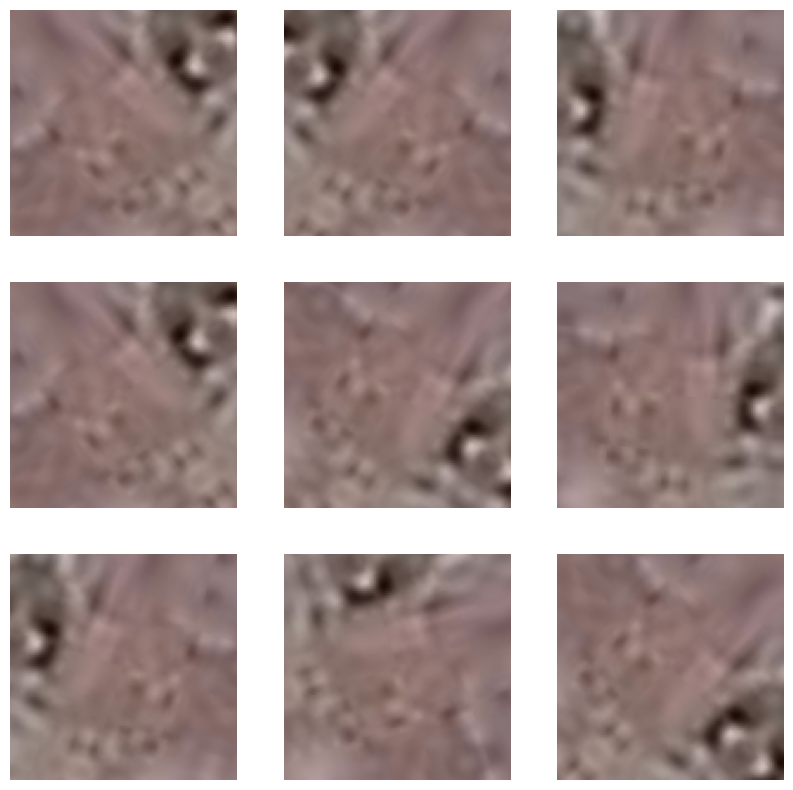

In [25]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')


In [26]:
# changes the range of pixes values to [-1, 1] for MobileNet
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [27]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [28]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 3, 3, 1280)


In [29]:
base_model.trainable = False

In [30]:
base_model.summary()

Model: "mobilenetv2_1.00_96"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 Conv1 (Conv2D)                 (None, 48, 48, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 48, 48, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 48, 48, 32)   0           ['bn_Conv1[0][0]']               
                                                                                

### Add layers to tune

In [31]:
def add_head_to_base_model(
    base_model, data_augmentation, preprocess_input, output_bias=None
):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    global_average_layer = layers.GlobalAveragePooling2D()
    prediction_layer = layers.Dense(
        1, 
        activation='sigmoid', 
        bias_initializer=output_bias
    )

    inputs = tf.keras.Input(shape=IMG_SHAPE)
    x = data_augmentation(inputs)
    x = preprocess_input(x)
    x = base_model(x, training=False)
    x = global_average_layer(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = prediction_layer(x)
    
    return tf.keras.Model(inputs, outputs)


In [32]:
def compile_model(model, learning_rate=0.0001):
    metrics = (
        tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy'),
        tf.keras.metrics.AUC(name='AUC')
    )
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=metrics)

In [59]:
def plot_curves(history):
    print(history.history.keys())

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    auc = history.history['AUC']
    val_auc = history.history['val_AUC']

    plt.figure(figsize=(8, 16))
    plt.subplot(3, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(3, 1, 2)
    plt.plot(loss, label='Training and Validation Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.title('Training and Validation Loss')

    plt.subplot(3, 1, 3)
    plt.plot(auc, label='AUC')
    plt.plot(val_auc, label='Validation AUC')
    plt.legend(loc='best')
    plt.ylabel('AUC')
    plt.title('Training and Validation AUC')
    plt.xlabel('epoch')
    plt.plot
    # plt.show()


In [34]:
model = add_head_to_base_model(base_model, preprocess_input, data_augmentation)

In [35]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 96, 96, 3)        0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 96, 96, 3)        0         
 a)                                                              
                                                                 
 sequential (Sequential)     (None, 96, 96, 3)         0         
                                                                 
 mobilenetv2_1.00_96 (Functi  (None, 3, 3, 1280)       2257984   
 onal)                                                           
                                                             

In [36]:
tf.keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [37]:
compile_model(model)

In [41]:
loss0, accuracy0, auc0 = model.evaluate(val_dataset)
print('Loss:', loss0)
print('Accuracy:', accuracy0)
print('AUC:', auc0)


110/110 [==============================] - 5s 43ms/step - loss: 0.7892 - accuracy: 0.4511 - AUC: 0.4500
Loss: 0.7891880869865417
Accuracy: 0.4511428475379944
AUC: 0.45003804564476013


In [42]:
INITIAL_EPOCHS = 10

history = model.fit(train_dataset,
                    epochs=INITIAL_EPOCHS,
                    validation_data=val_dataset)


Epoch 1/10


c:\Users\Adam\anaconda3\envs\machine_learning\lib\site-packages\keras\backend.py:5673: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


438/438 [==============================] - 36s 71ms/step - loss: 0.2880 - accuracy: 0.8745 - AUC: 0.9129 - val_loss: 0.3939 - val_accuracy: 0.8180 - val_AUC: 0.9818
Epoch 2/10
438/438 [==============================] - 31s 71ms/step - loss: 0.1437 - accuracy: 0.9489 - AUC: 0.9810 - val_loss: 0.2716 - val_accuracy: 0.8931 - val_AUC: 0.9902
Epoch 3/10
438/438 [==============================] - 31s 71ms/step - loss: 0.1139 - accuracy: 0.9586 - AUC: 0.9872 - val_loss: 0.2293 - val_accuracy: 0.9103 - val_AUC: 0.9934
Epoch 4/10
438/438 [==============================] - 32s 73ms/step - loss: 0.0981 - accuracy: 0.9646 - AUC: 0.9906 - val_loss: 0.2013 - val_accuracy: 0.9257 - val_AUC: 0.9951
Epoch 5/10
438/438 [==============================] - 32s 73ms/step - loss: 0.0873 - accuracy: 0.9681 - AUC: 0.9930 - val_loss: 0.1777 - val_accuracy: 0.9340 - val_AUC: 0.9962
Epoch 6/10
438/438 [==============================] - 32s 72ms/step - loss: 0.0805 - accuracy: 0.9692 - AUC: 0.9942 - val_loss: 0.1

dict_keys(['loss', 'accuracy', 'AUC', 'val_loss', 'val_accuracy', 'val_AUC'])


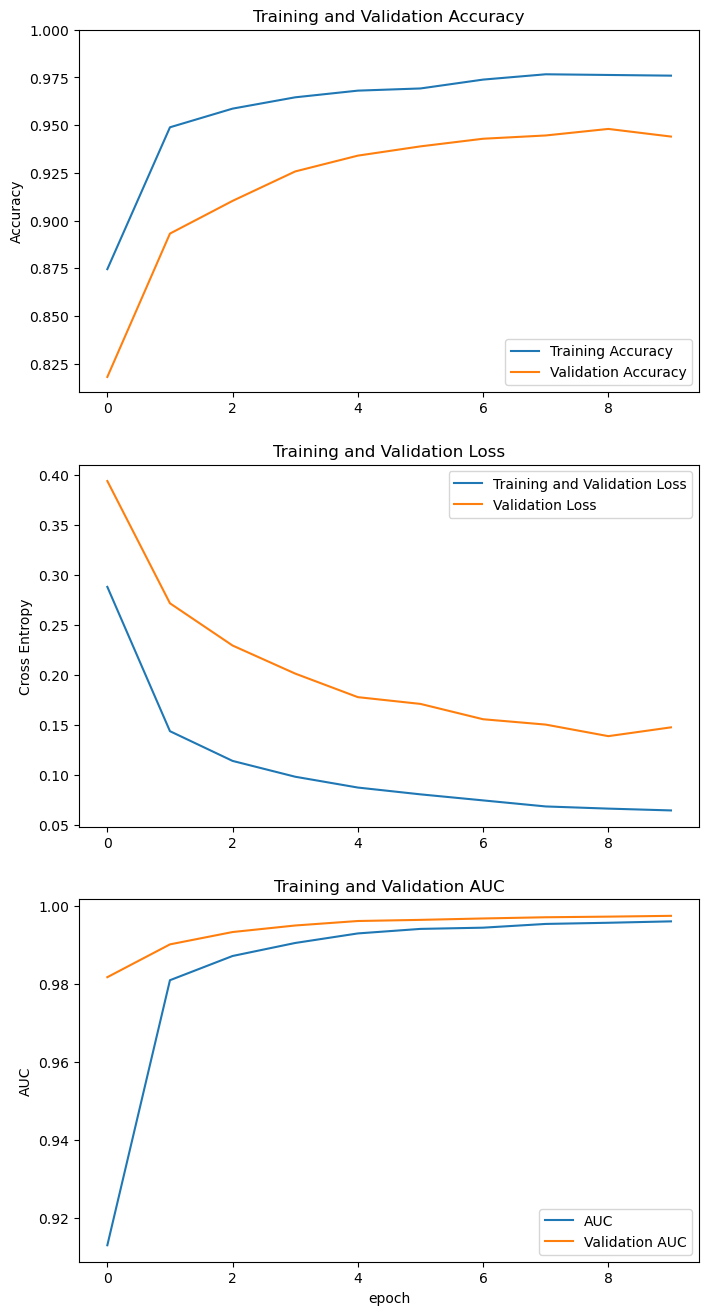

In [60]:
plot_curves(history)

We can see that the model is starting to overfit from epoch 8, since the training loss is decreasing but the validation loss is increasing.

In [61]:
# bias inputs to see if that improves results and/or speeds up convergence
initial_bias = np.log([pos_count/neg_count])
model = add_head_to_base_model(base_model, preprocess_input, data_augmentation, output_bias=initial_bias)

In [62]:
compile_model(model)

In [63]:
history = model.fit(train_dataset,
                    epochs=INITIAL_EPOCHS,
                    validation_data=val_dataset)

Epoch 1/10


c:\Users\Adam\anaconda3\envs\machine_learning\lib\site-packages\keras\backend.py:5673: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


438/438 [==============================] - 37s 73ms/step - loss: 0.4190 - accuracy: 0.7986 - AUC: 0.8269 - val_loss: 0.4623 - val_accuracy: 0.7517 - val_AUC: 0.9664
Epoch 2/10
438/438 [==============================] - 31s 71ms/step - loss: 0.1757 - accuracy: 0.9377 - AUC: 0.9725 - val_loss: 0.3034 - val_accuracy: 0.8774 - val_AUC: 0.9861
Epoch 3/10
438/438 [==============================] - 32s 73ms/step - loss: 0.1316 - accuracy: 0.9538 - AUC: 0.9835 - val_loss: 0.2474 - val_accuracy: 0.9089 - val_AUC: 0.9914
Epoch 4/10
438/438 [==============================] - 32s 73ms/step - loss: 0.1103 - accuracy: 0.9614 - AUC: 0.9887 - val_loss: 0.2138 - val_accuracy: 0.9234 - val_AUC: 0.9939
Epoch 5/10
438/438 [==============================] - 32s 74ms/step - loss: 0.0981 - accuracy: 0.9646 - AUC: 0.9911 - val_loss: 0.1884 - val_accuracy: 0.9294 - val_AUC: 0.9954
Epoch 6/10
438/438 [==============================] - 32s 74ms/step - loss: 0.0866 - accuracy: 0.9681 - AUC: 0.9933 - val_loss: 0.1

dict_keys(['loss', 'accuracy', 'AUC', 'val_loss', 'val_accuracy', 'val_AUC'])


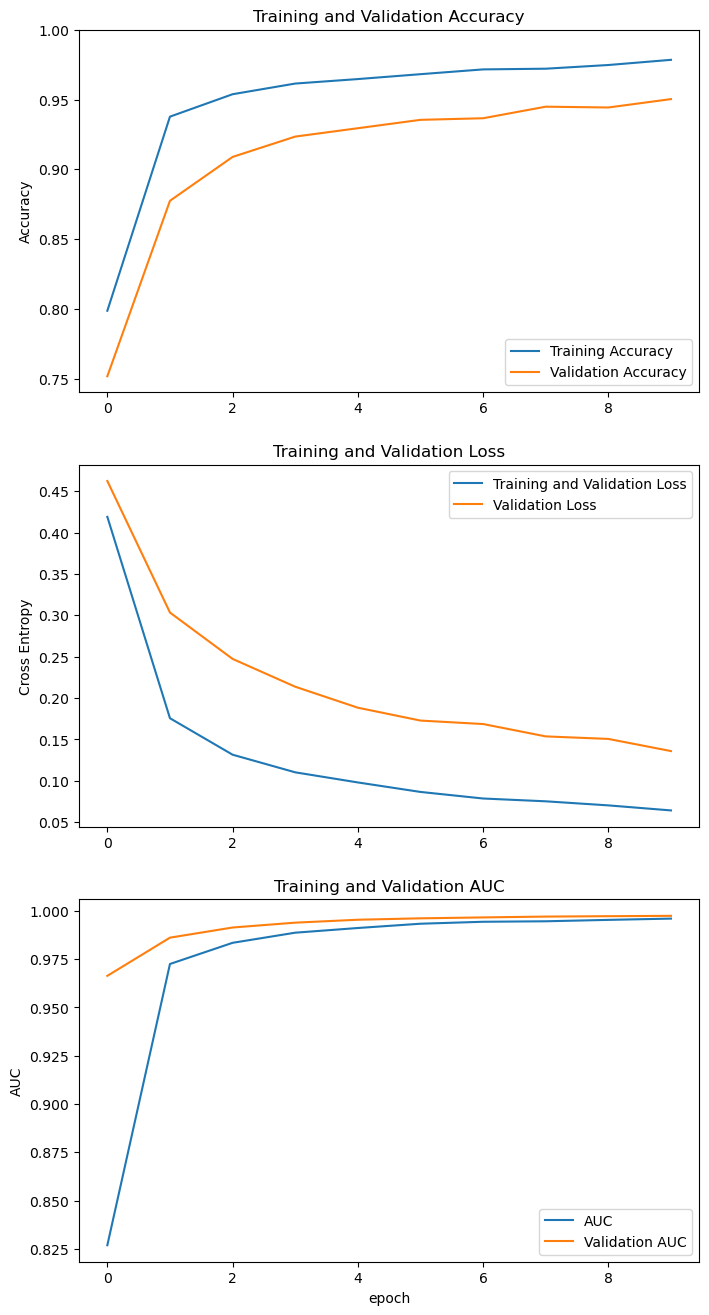

In [64]:
plot_curves(history)

- Weighting the classes seems to slightly improve the model's accuracy
- More importantly it appears to reduce overfitting
- However, repeats of the experiment using K-fold cross validations should be done to confirm that this is generally true